# Start: my first kaggle submission!

## To use this notebook I am assuming that you have already downloaded the files

- test-jpg-additional.tar
- test-jpg.tar.7z
- train-jpg.tar.7z
- train_v2.csv.zip

## from [kaggle](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) and unzip all them in the folder "data".

In [1]:
# All imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
toolsdir = os.path.join(parentdir, "tools")
sys.path.insert(0, toolsdir)
sys.path.insert(0, parentdir)


from Config import Config
from CNN import CNNModel, train_model, check_valid, test_prediction
from DataHolder import DataHolder
from util import randomize_in_place
from DataManager import DataManager

## We will use the jpg dataset with images of size 28x28 

In [2]:
data_dir = os.path.join(parentdir, "data")
my_data = DataManager(data_dir)

## Printing some examples

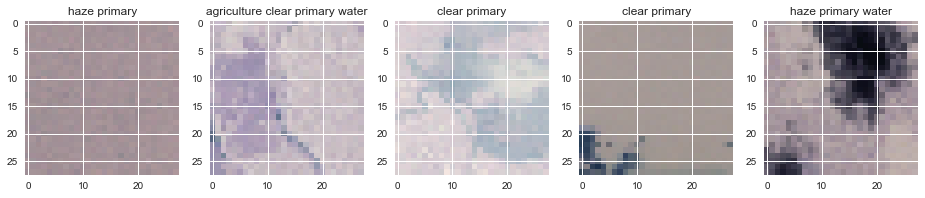

In [3]:
X_train = my_data.data['X_train']
y_train = my_data.data['y_train']
X_test = my_data.data['X_test']
X_test_add = my_data.data['X_test_add']
examples = X_train[0:5]
example_cls = ["haze primary",
               "agriculture clear primary water",
               "clear primary",
               "clear primary",
               "haze primary water"]
tuples = list(zip(examples,example_cls))
fig = plt.figure()
fig.set_size_inches(16, 4)
for i, (x, c) in enumerate((tuples) ):
    a = fig.add_subplot(1, 5, i+1)
    a.set_title(c)
    plt.imshow(x)

## Spliting the data in train and valid datasets

In [4]:
randomize_in_place(X_train, y_train, 0)
X_valid, y_valid = X_train[40000: 40479], y_train[40000: 40479]
X_train, y_train = X_train[0:40000], y_train[0:40000]

print("image shape train = ", X_train.shape)
print("label shape train = ", y_train.shape)
print("image shape valid = ", X_valid.shape)
print("label shape valid = ", y_valid.shape)

image shape train =  (40000, 28, 28, 3)
label shape train =  (40000, 17)
image shape valid =  (479, 28, 28, 3)
label shape valid =  (479, 17)


## Let's train the model! 

In [5]:
lr = 0.0928467676
my_dataholder = DataHolder(X_train,
                           y_train,
                           X_valid,
                           y_valid,
                           X_test,
                           X_test_add)
my_config = Config(batch_size=120,
                   learning_rate=lr)
my_model = CNNModel(my_config, my_dataholder)
train_model(my_model, my_dataholder, 4001, 1000)


Start training
step  batch_F2  valid_F2  elapsed_time
  0   0.44        0.45*    0.22(s)
1000   0.57        0.61*    0.19(s)
2000   0.66        0.62*    0.18(s)
3000   0.67        0.68*    0.18(s)
4000   0.69        0.70*    0.18(s)

&&&&&&&&& #training steps = 4001 &&&&&&&&&&&
training time: 0:0:12:51 (DAYS:HOURS:MIN:SEC)

&&&&&&&&& For TensorBoard visualization type &&&&&&&&&&&

tensorboard  --logdir=logs/26-05-2017_15-28-57



In [8]:
# !tensorboard  --logdir=./logs/

## After the training we can see what is the F2 score

The F2 score in the valid dataset works as a preview of the kaggle score. For example, in my first submission the valid dataset score was **0.70318** and the kaggle score was **0.73522**.

In [6]:
print("valid dataset score = {:.5f}".format(check_valid(my_model)))

valid dataset score = 0.70209


## Now we can create a submission as a csv file

In [7]:
test_pred = test_prediction(my_model)
test_pred_add = test_prediction(my_model, add=True)
my_data.get_submission(test_pred, test_pred_add)

## We can explore our submission file to see what what ou model is doing

In [11]:
labels_df = pd.read_csv('submission.csv')
labels_df.fillna("clear primary",inplace=True)

# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
            
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

# Histogram of label instances
labels_df[label_list].sum().sort_values()

artisinal_mine       42
water               420
cloudy             2726
partly_cloudy      2845
haze               3731
road               4891
agriculture       18178
clear             44880
primary           58031
dtype: int64

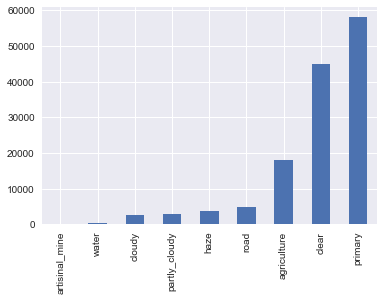

In [12]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

,clear,primary,partly_cloudy,agriculture,haze,cloudy,road,water,artisinal_mine
clear,44880,44526,2,13657,0,0,4770,371,39
primary,44526,58031,2747,18172,3369,42,4891,403,42
partly_cloudy,2,2747,2845,581,0,87,0,3,0
agriculture,13657,18172,581,18178,0,0,4706,164,0
haze,0,3369,0,0,3731,272,0,0,0
cloudy,0,42,87,0,272,2726,0,0,0
road,4770,4891,0,4706,0,0,4891,201,16
water,371,403,3,164,0,0,201,420,42
artisinal_mine,39,42,0,0,0,0,16,42,42


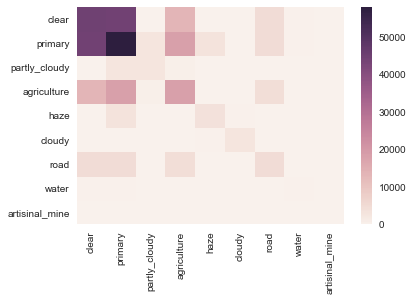

In [13]:
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

,clear,partly_cloudy,haze,cloudy
clear,44880,2,0,0
partly_cloudy,2,2845,0,87
haze,0,0,3731,272
cloudy,0,87,272,2726


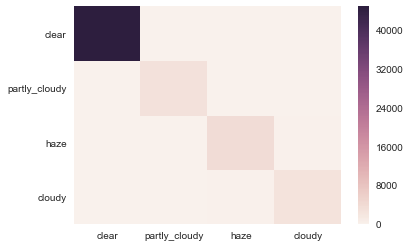

In [14]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

,primary,agriculture,water
primary,58031,18172,403
agriculture,18172,18178,164
water,403,164,420


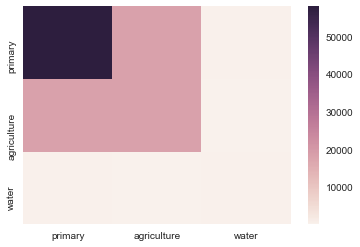

In [16]:
land_labels = ['primary', 'agriculture', 'water']
make_cooccurence_matrix(land_labels)

,water,artisinal_mine
water,420,42
artisinal_mine,42,42


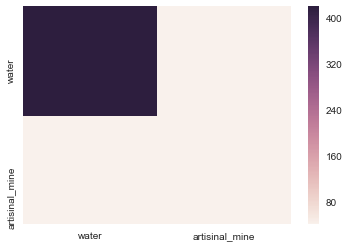

In [17]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)